/tmp/ipython-input-1-1451154329.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(['BTC-USD', 'TSLA'], start='2023-01-01', end='2024-12-31')
[*********************100%***********************]  2 of 2 completed
/tmp/ipython-input-1-1451154329.py:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()


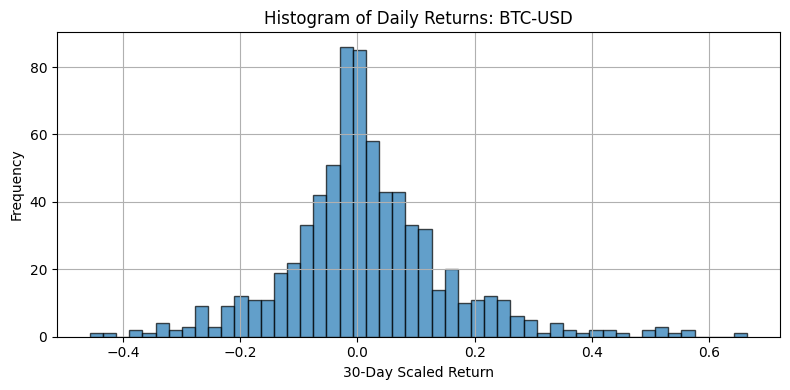

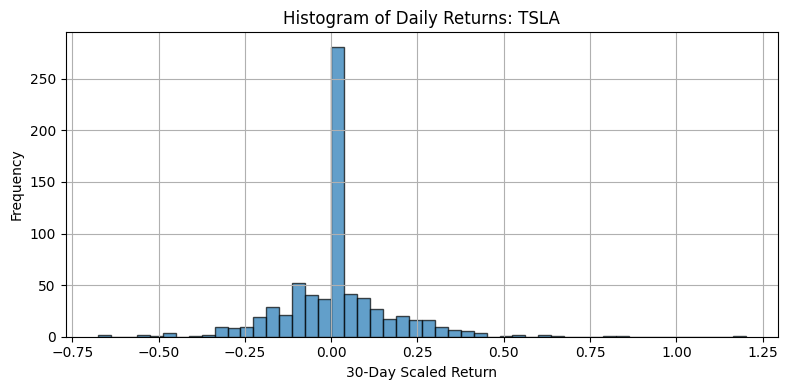

30-Day Conditional Value at Risk (CVaR) at 95% Confidence:
BTC-USD: 0.2835
TSLA: 0.3531


In [1]:
# Historical CVaR Calculation
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Download historical price data
data = yf.download(['BTC-USD', 'TSLA'], start='2023-01-01', end='2024-12-31')
prices = data["Close"]

# Step 2: Compute daily returns
returns = prices.pct_change().dropna()

# Step 3: Set parameters
confidence = 0.95
days = 30

# Step 4: Plot histogram of daily returns (scaled to 30-day)
for asset in returns.columns:
    plt.figure(figsize=(8, 4))
    plt.hist(returns[asset] * np.sqrt(days), bins=50, edgecolor='black', alpha=0.7)
    plt.title(f"Histogram of Daily Returns: {asset}")
    plt.xlabel("30-Day Scaled Return")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 5: Compute CVaR (Expected Shortfall) for each asset
cvar_daily = {}
for asset in returns.columns:
    sorted_losses = np.sort(returns[asset])
    threshold_index = int((1 - confidence) * len(sorted_losses))
    avg_loss_below_var = sorted_losses[:threshold_index].mean()
    cvar_daily[asset] = -avg_loss_below_var  # make it positive

# Step 6: Scale to 30-day CVaR assuming IID
cvar_30d = {asset: cvar * np.sqrt(days) for asset, cvar in cvar_daily.items()}

# Step 7: Display results
print("30-Day Conditional Value at Risk (CVaR) at 95% Confidence:")
for asset, cvar in cvar_30d.items():
    print(f"{asset}: {cvar:.4f}")

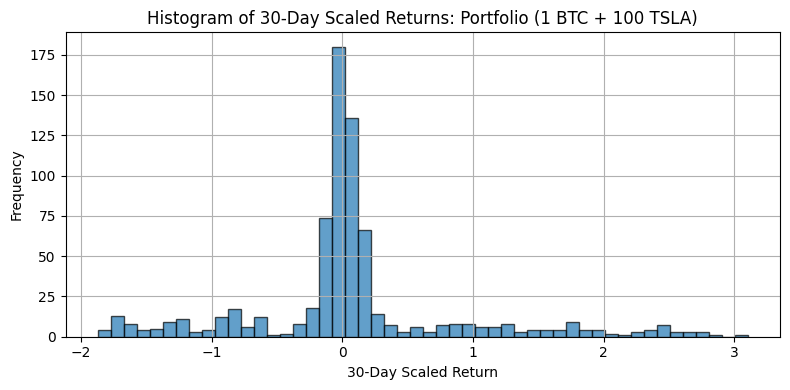


30-Day Portfolio CVaR (95% Confidence) for 1 BTC + 50 TSLA:
1.6243


In [2]:
# Step 8: Define portfolio holdings
holdings = {'BTC-USD': 1, 'TSLA': 50}

# Step 9: Calculate daily portfolio value
portfolio_value = (prices[['BTC-USD', 'TSLA']] * pd.Series(holdings)).sum(axis=1)

# Step 10: Calculate daily returns of the portfolio
portfolio_returns = portfolio_value.pct_change().dropna()

# Step 11: Plot histogram of portfolio returns scaled to 30-day
plt.figure(figsize=(8, 4))
plt.hist(portfolio_returns * np.sqrt(days), bins=50, edgecolor='black', alpha=0.7)
plt.title("Histogram of 30-Day Scaled Returns: Portfolio (1 BTC + 100 TSLA)")
plt.xlabel("30-Day Scaled Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


# Step 12: Compute 1-day portfolio CVaR
sorted_returns = np.sort(portfolio_returns)
threshold_index = int((1 - confidence) * len(sorted_returns))
portfolio_cvar_daily = -sorted_returns[:threshold_index].mean()  # average of worst losses

# Step 13: Compute 30-day portfolio CVaR (scale up assuming IID)
portfolio_cvar_30d = portfolio_cvar_daily * np.sqrt(days)

# Step 14: Display the result
print("\n30-Day Portfolio CVaR (95% Confidence) for 1 BTC + 50 TSLA:")
print(f"{portfolio_cvar_30d:.4f}")

/tmp/ipython-input-3-3512723375.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  2 of 2 completed



30-Day Simulated Portfolio VaR (95% Confidence) for 1 BTC + 100 TSLA:
0.1974


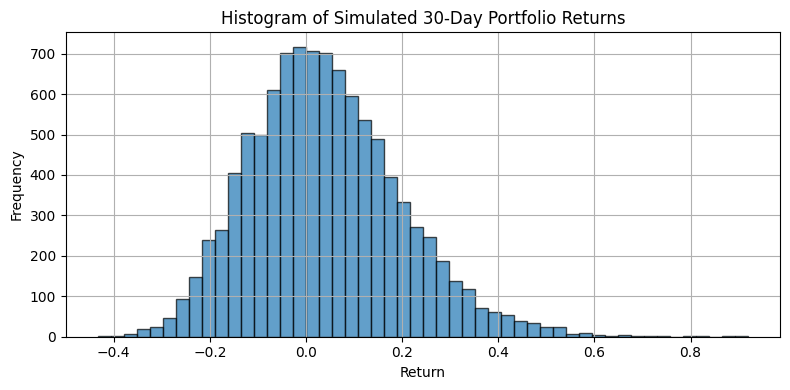

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Step 0: Download historical prices
tickers = ['BTC-USD', 'TSLA']
holdings = {'BTC-USD': 1, 'TSLA': 100}
start_date = '2022-01-01'
end_date = '2024-12-31'

data = yf.download(tickers, start=start_date, end=end_date)['Close']
prices = data.dropna()

# Parameters
confidence = 0.95
days = 30
n_simulations = 10000
dt = 1 / 252  # daily step in year units

# Step 1: Daily log returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Step 2: Estimate annualized drift and volatility
mu_log_annual = log_returns.mean() * 252              # (mu - 0.5 sigma^2)
sigma_annual = log_returns.std() * np.sqrt(252)       # annualized sigma

# Step 3: Recover GBM drift mu
mu = mu_log_annual + 0.5 * sigma_annual ** 2

# Step 4: Simulate GBM paths
np.random.seed(42)
simulated_prices = {}

for ticker in tickers:
    S0 = prices[ticker].iloc[-1]
    Z = np.random.standard_normal((days, n_simulations))
    path = np.zeros((days + 1, n_simulations))
    path[0] = S0
    for t in range(1, days + 1):
        path[t] = path[t - 1] * np.exp(
            (mu[ticker] - 0.5 * sigma_annual[ticker]**2) * dt +
            sigma_annual[ticker] * np.sqrt(dt) * Z[t - 1]
        )
    simulated_prices[ticker] = path

# Step 5: Compute final portfolio values
initial_value = sum(holdings[t] * prices[t].iloc[-1] for t in tickers)
final_values = sum(holdings[t] * simulated_prices[t][-1] for t in tickers)
portfolio_returns_sim = (final_values - initial_value) / initial_value

# Step 6: Compute 30-day VaR
var_30d_sim = -np.percentile(portfolio_returns_sim, (1 - confidence) * 100)

# Step 7: Output
print(f"\n30-Day Simulated Portfolio VaR (95% Confidence) for 1 BTC + 100 TSLA:")
print(f"{var_30d_sim:.4f}")

# Step 8: Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(portfolio_returns_sim, bins=50, edgecolor='black', alpha=0.7)
plt.title("Histogram of Simulated 30-Day Portfolio Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
portfolio_returns_sim  # simulated 30-day returns
var_30d_sim            # previously computed VaR (negative value)
confidence = 0.95

# Step 7.5: Compute Conditional VaR (CVaR / Expected Shortfall)
cvar_30d_sim = -portfolio_returns_sim[portfolio_returns_sim <= -var_30d_sim].mean()

# Display results
print(f"30-Day Simulated Portfolio CVaR (95% Confidence):")
print(f"{cvar_30d_sim:.4f}")

30-Day Simulated Portfolio CVaR (95% Confidence):
0.2419
